In [1]:
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
from polygon import RESTClient
import talib
from polygon_keys import polygon_key

In [2]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['font.family'] = 'serif'

In [3]:
def get_data_by_hour(symbol):
    key = polygon_key
    client = RESTClient(key)
    query = True
    from_date = "2012-01-01"
    to_date = (datetime.today().date() + timedelta(days = 1)).strftime("%Y-%m-%d")
    now_date = datetime.today().date().strftime("%Y-%m-%d")
    data_for_df = []
    while query:
        print(from_date, now_date)
        resp = client.stocks_equities_aggregates(symbol, 1, "hour", from_date, to_date, unadjusted=False, limit=50000)
        if 'results' in dir(resp):
            results = resp.results
            data_for_df = data_for_df + results[:-1]
            date = datetime.fromtimestamp((resp.results[-1]['t'])/1000.0)
            if date.date().strftime("%Y-%m-%d") == from_date:
                query = False
            from_date = date.date().strftime("%Y-%m-%d")
            if from_date == now_date:
                query = False 
        else:
            query = False 

    
    handledData = pd.DataFrame(data=data_for_df)
    handledData.columns = ['volume', 'vw', 'open', 'close', 'high', 'low', 'time', 'number']
    handledData.drop_duplicates(subset=['time'], inplace=True)
    handledData.index = pd.to_datetime(handledData['time'].values, unit='ms').to_pydatetime()
    handledData.index = handledData.index + timedelta(hours = 3)
    handledData.drop('time', axis=1, inplace=True)
    handledData.dropna(inplace=True)

    plt.figure(figsize=(15, 5))
    plt.plot(handledData.index, handledData['close'])
    plt.grid(True)
    return handledData

2012-01-01 2021-07-14
2012-06-21 2021-07-14
2012-12-04 2021-07-14
2013-05-16 2021-07-14
2013-10-17 2021-07-14
2014-03-28 2021-07-14
2014-09-11 2021-07-14
2015-02-26 2021-07-14
2015-08-06 2021-07-14
2016-01-27 2021-07-14
2016-07-08 2021-07-14
2016-12-01 2021-07-14
2017-03-31 2021-07-14
2017-07-20 2021-07-14
2017-11-02 2021-07-14
2018-02-27 2021-07-14
2018-06-20 2021-07-14
2018-09-28 2021-07-14
2019-01-08 2021-07-14
2019-04-22 2021-07-14
2019-07-31 2021-07-14
2019-11-08 2021-07-14
2020-02-20 2021-07-14
2020-05-18 2021-07-14
2020-08-24 2021-07-14
2020-12-01 2021-07-14
2021-03-16 2021-07-14
2021-06-29 2021-07-14


,volume,vw,open,close,high,low,number
2012-01-03 15:00:00,1100.0,5.5000,5.50,5.50,5.500,5.5000,6
2012-01-03 16:00:00,24951.0,5.5243,5.48,5.54,5.540,5.4800,29
2012-01-03 17:00:00,1359139.0,5.5509,5.40,5.55,5.590,5.4000,3115
2012-01-03 18:00:00,2822896.0,5.5226,5.55,5.52,5.580,5.4500,5652
2012-01-03 19:00:00,1179854.0,5.4913,5.52,5.49,5.525,5.4700,2604
...,...,...,...,...,...,...,...
2021-07-14 02:00:00,15300.0,90.2410,90.28,90.12,90.300,90.1200,122
2021-07-14 12:00:00,4921.0,90.6204,90.29,90.66,90.740,90.2900,50
2021-07-14 13:00:00,300.0,90.6747,90.68,90.68,90.680,90.6800,5
2021-07-14 14:00:00,32905.0,90.6276,90.63,90.74,90.750,90.4100,461


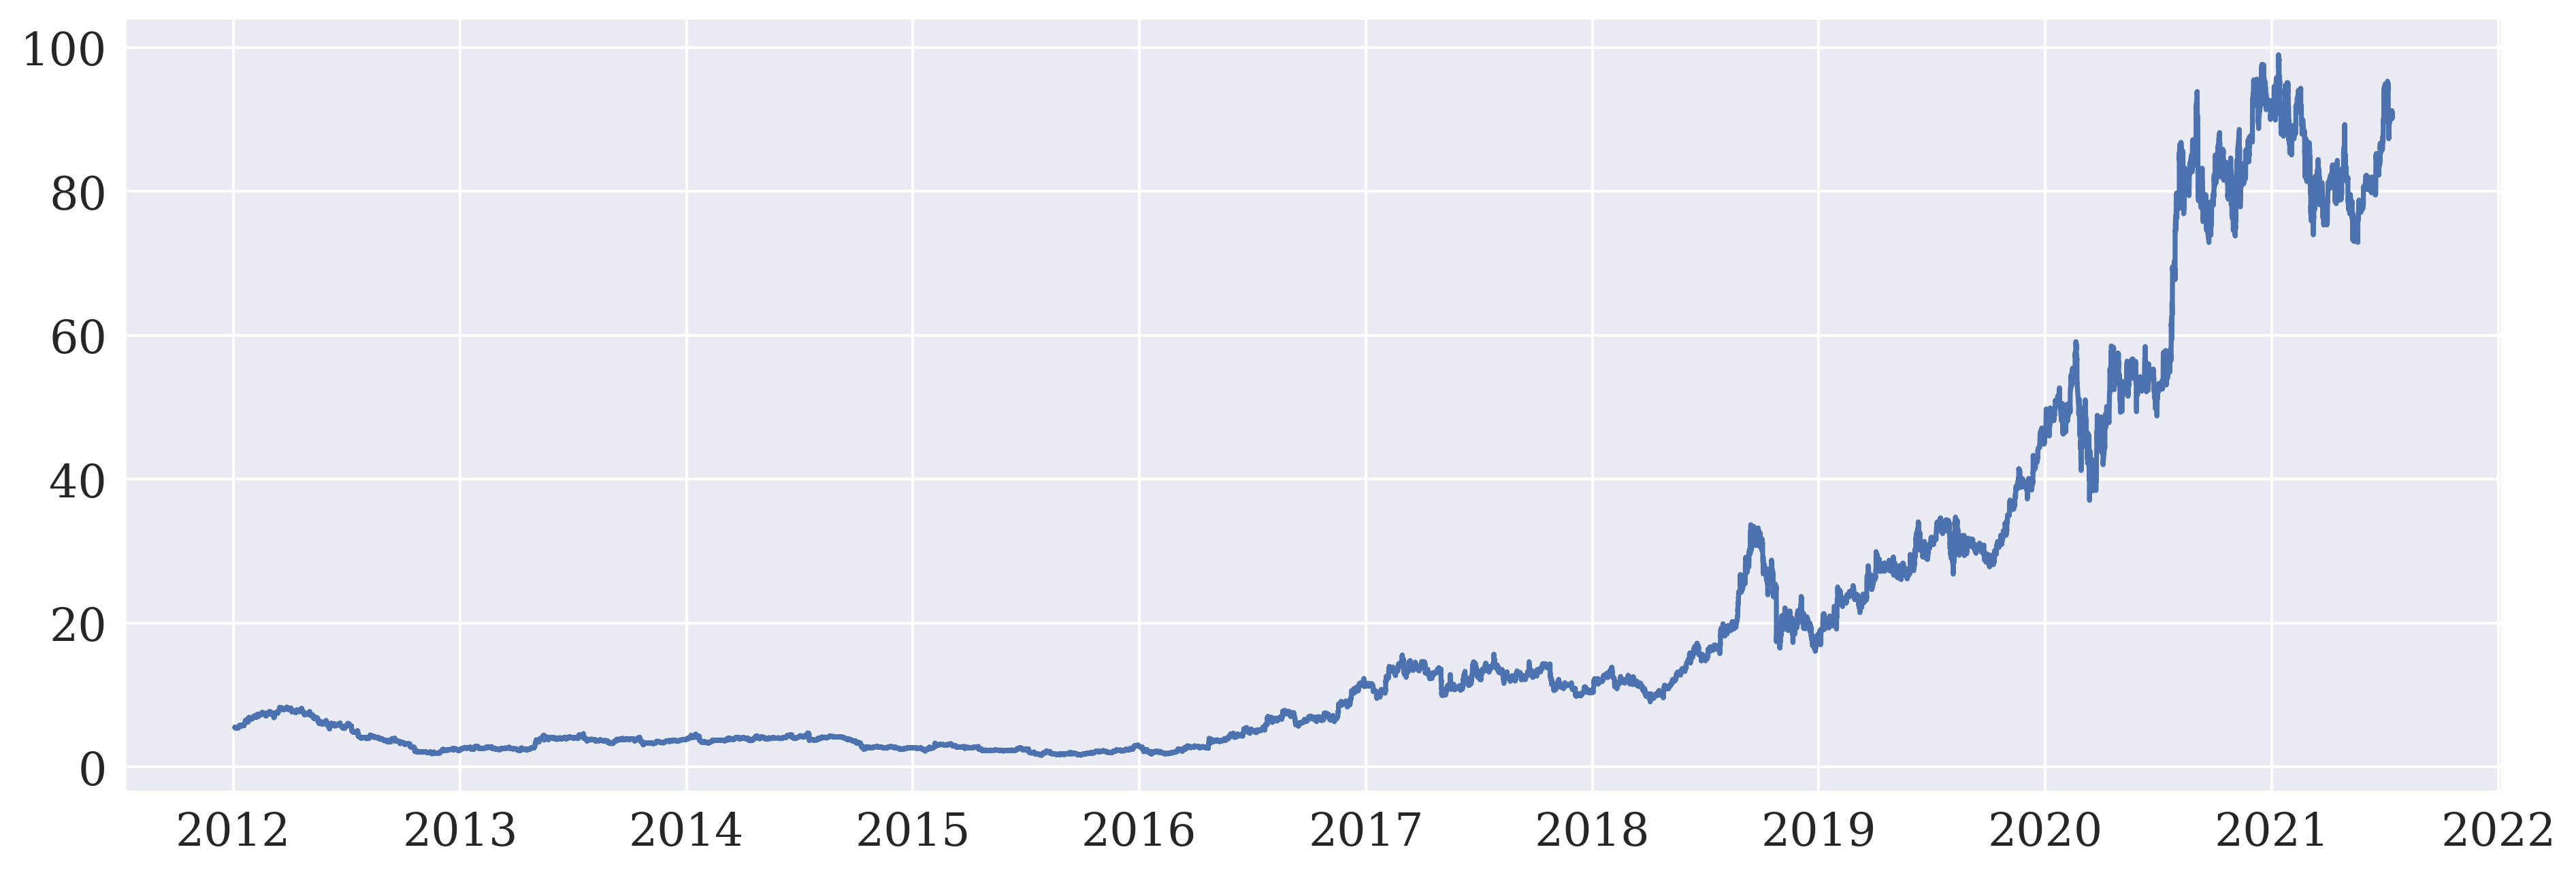

In [4]:
symbol = "AMD"
data_stock = get_data_by_hour(symbol)
data_stock

In [5]:
data_stock

,volume,vw,open,close,high,low,number
2012-01-03 15:00:00,1100.0,5.5000,5.50,5.50,5.500,5.5000,6
2012-01-03 16:00:00,24951.0,5.5243,5.48,5.54,5.540,5.4800,29
2012-01-03 17:00:00,1359139.0,5.5509,5.40,5.55,5.590,5.4000,3115
2012-01-03 18:00:00,2822896.0,5.5226,5.55,5.52,5.580,5.4500,5652
2012-01-03 19:00:00,1179854.0,5.4913,5.52,5.49,5.525,5.4700,2604
...,...,...,...,...,...,...,...
2021-07-14 02:00:00,15300.0,90.2410,90.28,90.12,90.300,90.1200,122
2021-07-14 12:00:00,4921.0,90.6204,90.29,90.66,90.740,90.2900,50
2021-07-14 13:00:00,300.0,90.6747,90.68,90.68,90.680,90.6800,5
2021-07-14 14:00:00,32905.0,90.6276,90.63,90.74,90.750,90.4100,461


In [6]:
real =  talib.MFI(data_stock['high'], data_stock['low'], data_stock['close'], data_stock['volume'], timeperiod=14)

real[-250:]

2021-06-21 16:00:00    40.481439
2021-06-21 17:00:00    23.463440
2021-06-21 18:00:00    36.413223
2021-06-21 19:00:00    47.691095
2021-06-21 20:00:00    28.381764
                         ...    
2021-07-14 02:00:00    48.967600
2021-07-14 12:00:00    48.973112
2021-07-14 13:00:00    49.016652
2021-07-14 14:00:00    49.271569
2021-07-14 15:00:00    58.196426
Length: 250, dtype: float64

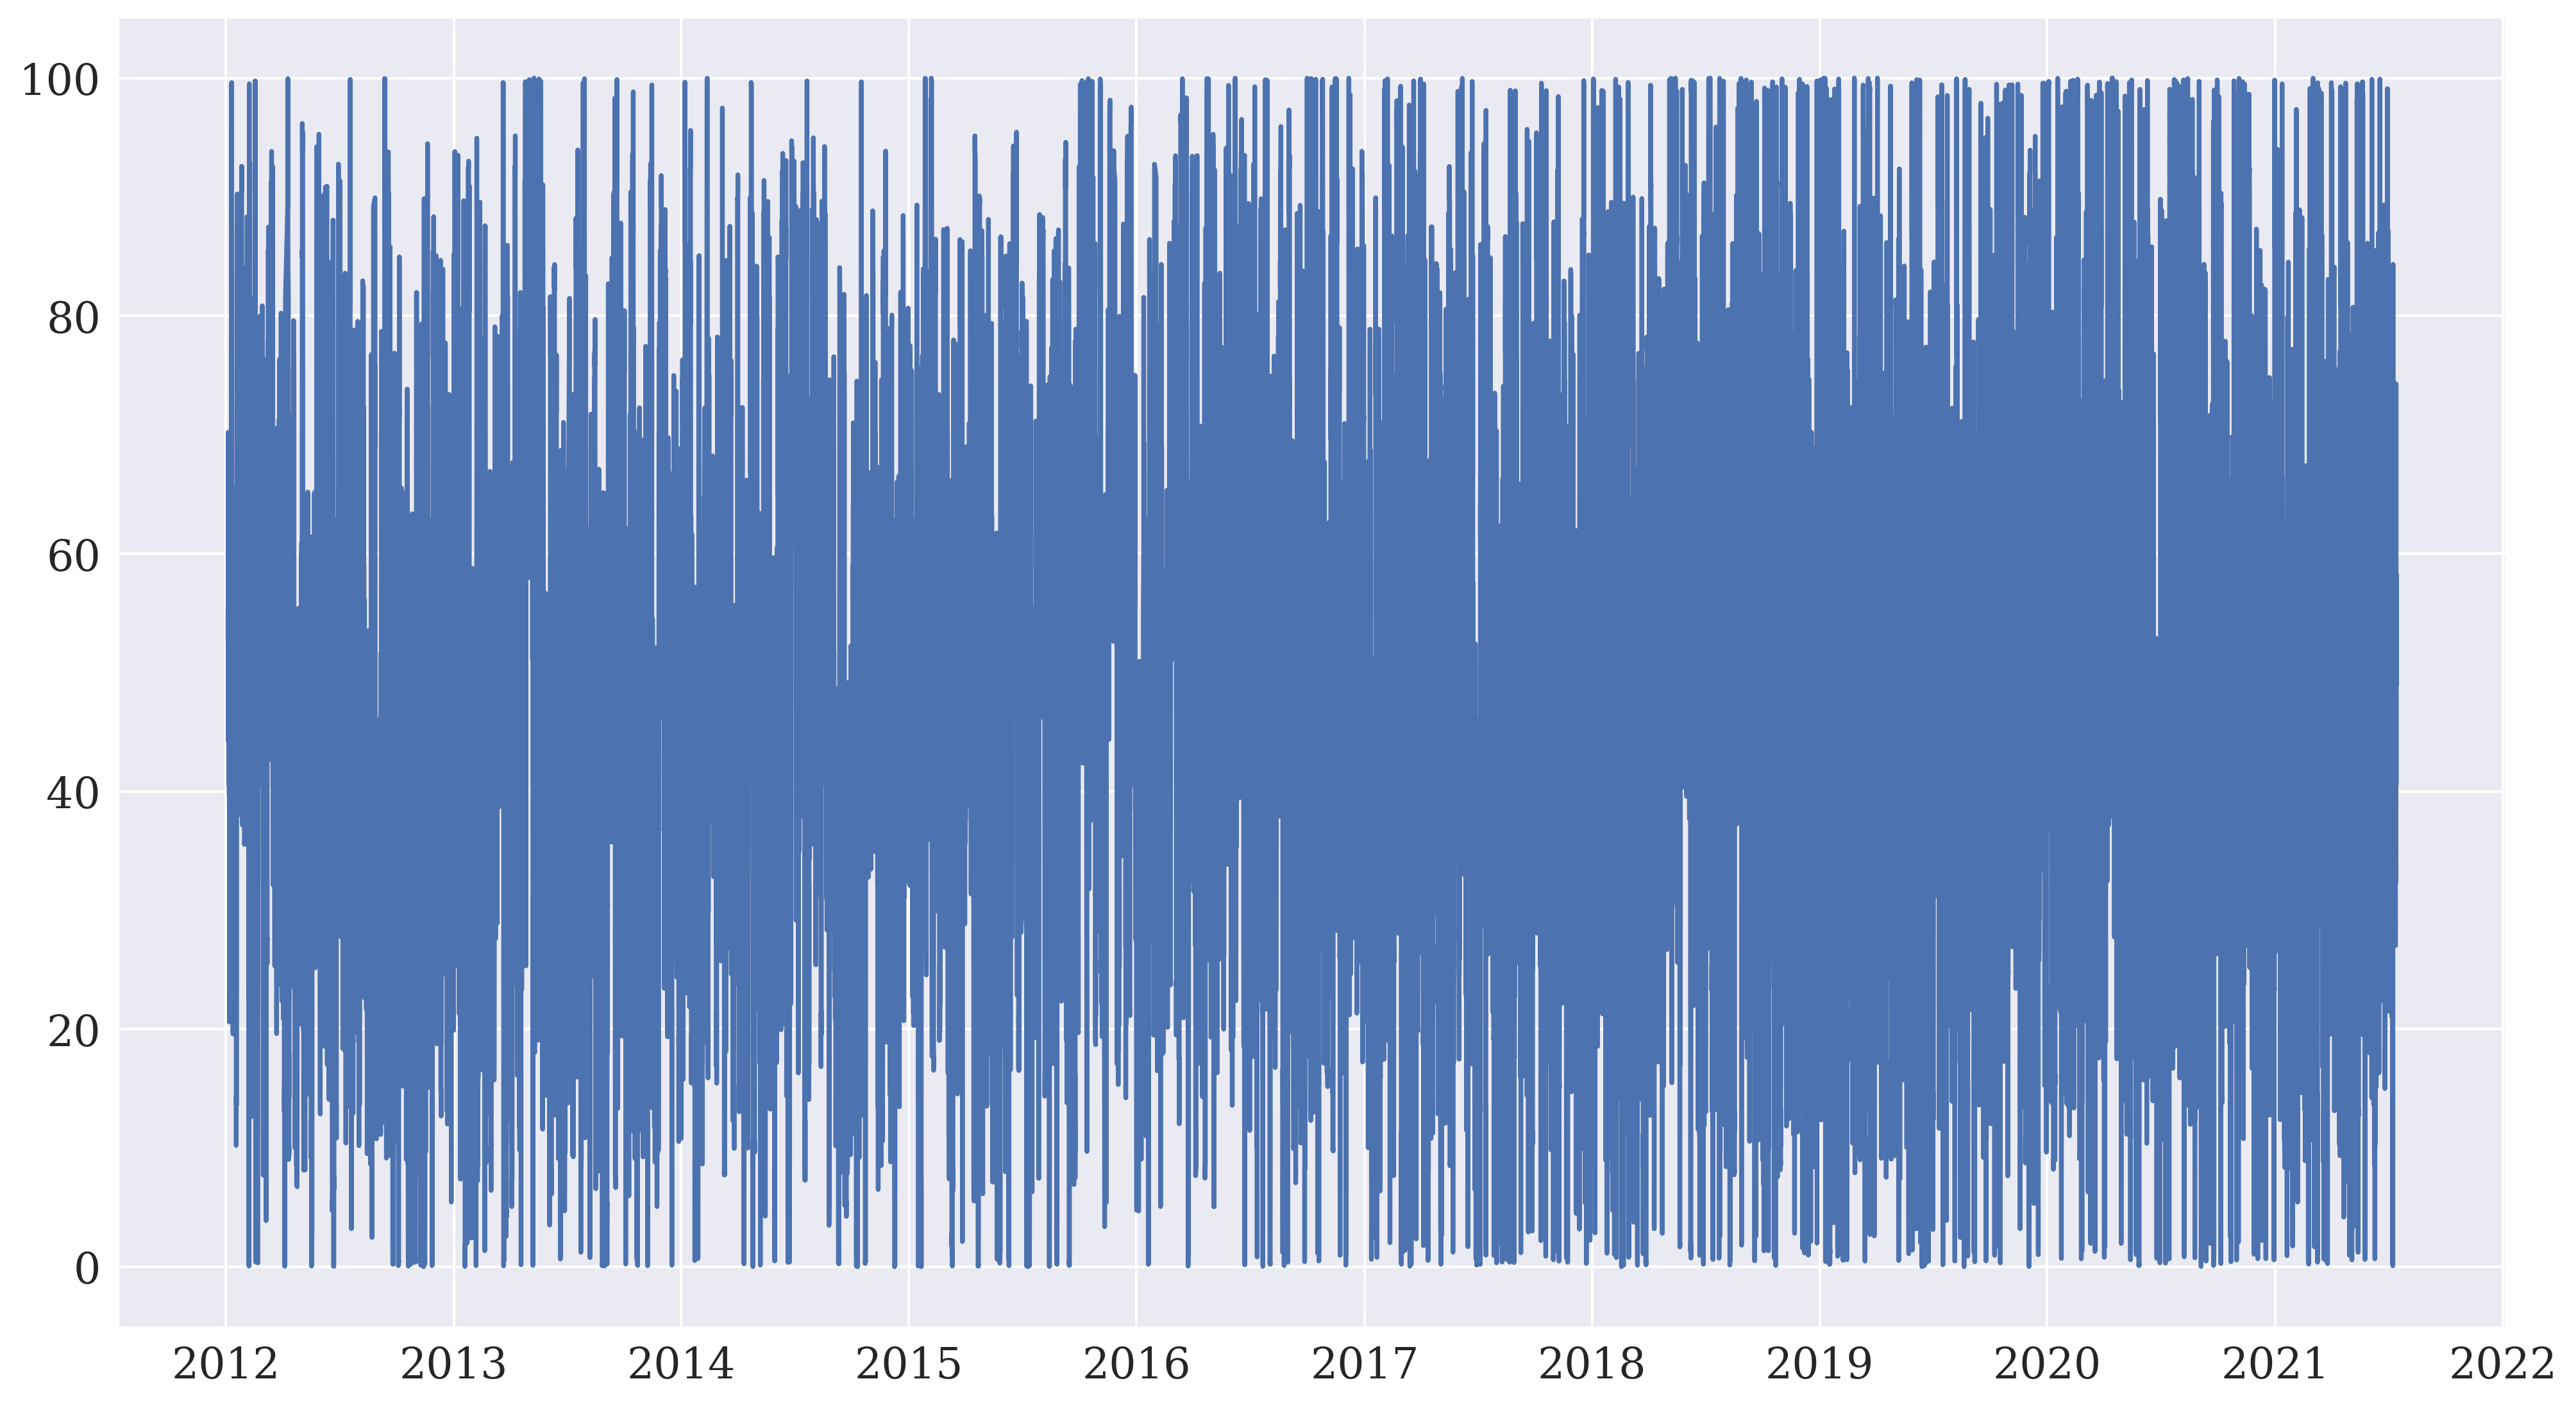

In [7]:
fig,ax = plt.subplots()

ax.plot(real)

In [8]:
price = data_stock['close']


def get_Daily_Volatility(close,span0=24):
    # simple percentage returns
    df0=close.pct_change()
    # 20 days, a month EWM's std as boundary
    df0=df0.ewm(span=span0).std()
    df0.dropna(inplace=True)
    return df0
df0 = get_Daily_Volatility(price)

#set the boundary of barriers, based on 20 days EWM
daily_volatility = get_Daily_Volatility(price)
# how many days we hold the stock which set the vertical barrier
t_final = 10
#the up and low boundary multipliers
upper_lower_multipliers = [3, 2]
#allign the index
prices = price[daily_volatility.index]

def get_3_barriers():
    #create a container
    barriers = pd.DataFrame(columns=['days_passed', 'price', 'vert_barrier', 'top_barrier', 'bottom_barrier'], index = daily_volatility.index)
    for day, vol in daily_volatility.iteritems():
        days_passed = len(daily_volatility.loc[daily_volatility.index[0] : day])
        #set the vertical barrier 
        if (days_passed + t_final < len(daily_volatility.index) \
            and t_final != 0):
            vert_barrier = daily_volatility.index[
                                days_passed + t_final]
        else:
            vert_barrier = np.nan
        #set the top barrier
        if upper_lower_multipliers[0] > 0:
            top_barrier = prices.loc[day] + prices.loc[day] * \
                          upper_lower_multipliers[0] * vol
        else:
            #set it to NaNs
            top_barrier = pd.Series(index=prices.index)
        #set the bottom barrier
        if upper_lower_multipliers[1] > 0:
            bottom_barrier = prices.loc[day] - prices.loc[day] * \
                          upper_lower_multipliers[1] * vol
        else: 
            #set it to NaNs
            bottom_barrier = pd.Series(index=prices.index)
        barriers.loc[day, ['days_passed', 'price', \
        'vert_barrier','top_barrier', 'bottom_barrier']] = \
         days_passed, prices.loc[day], vert_barrier, \
         top_barrier, bottom_barrier
    barriers['out'] = None
    return barriers


barriers = get_3_barriers()

def get_labels():
    for i in range(len(barriers.index)):
        start = barriers.index[i]
        end = barriers.vert_barrier[i]
        if pd.notna(end):
                # assign the initial and final price
                price_initial = barriers.price[start]
                price_final = barriers.price[end]
    # assign the top and bottom barriers
                top_barrier = barriers.top_barrier[i]
                bottom_barrier = barriers.bottom_barrier[i]
    #set the profit taking and stop loss conditons
                condition_pt = (barriers.price[start: end] >= \
                 top_barrier).any()
                condition_sl = (barriers.price[start: end] <= \
                 bottom_barrier).any()
    #assign the labels
                if condition_pt: 
                    barriers['out'][i] = 1
                elif condition_sl: 
                    barriers['out'][i] = -1    
                else: 
                    barriers['out'][i] = 0
    return

get_labels()

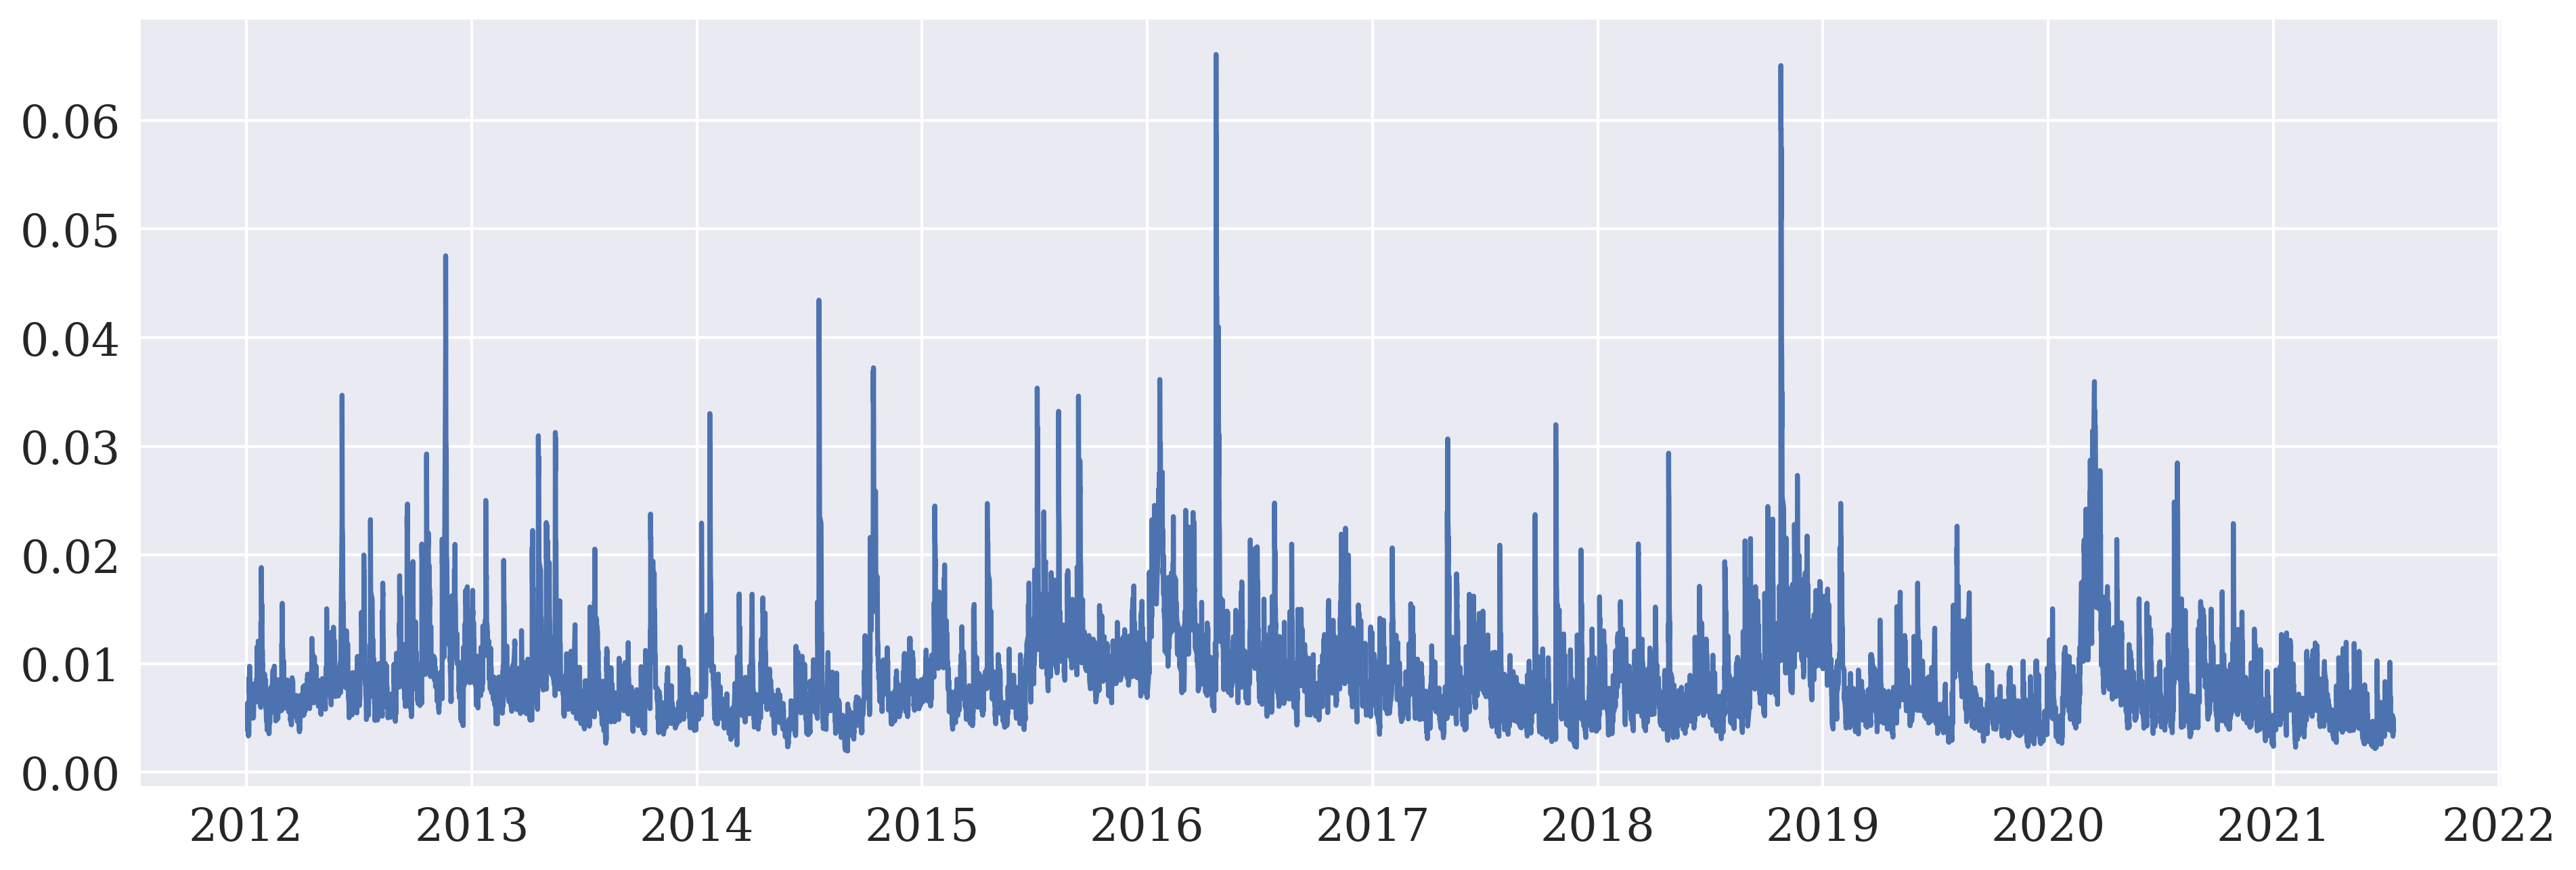

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(df0.index, df0.values)
plt.grid(True)

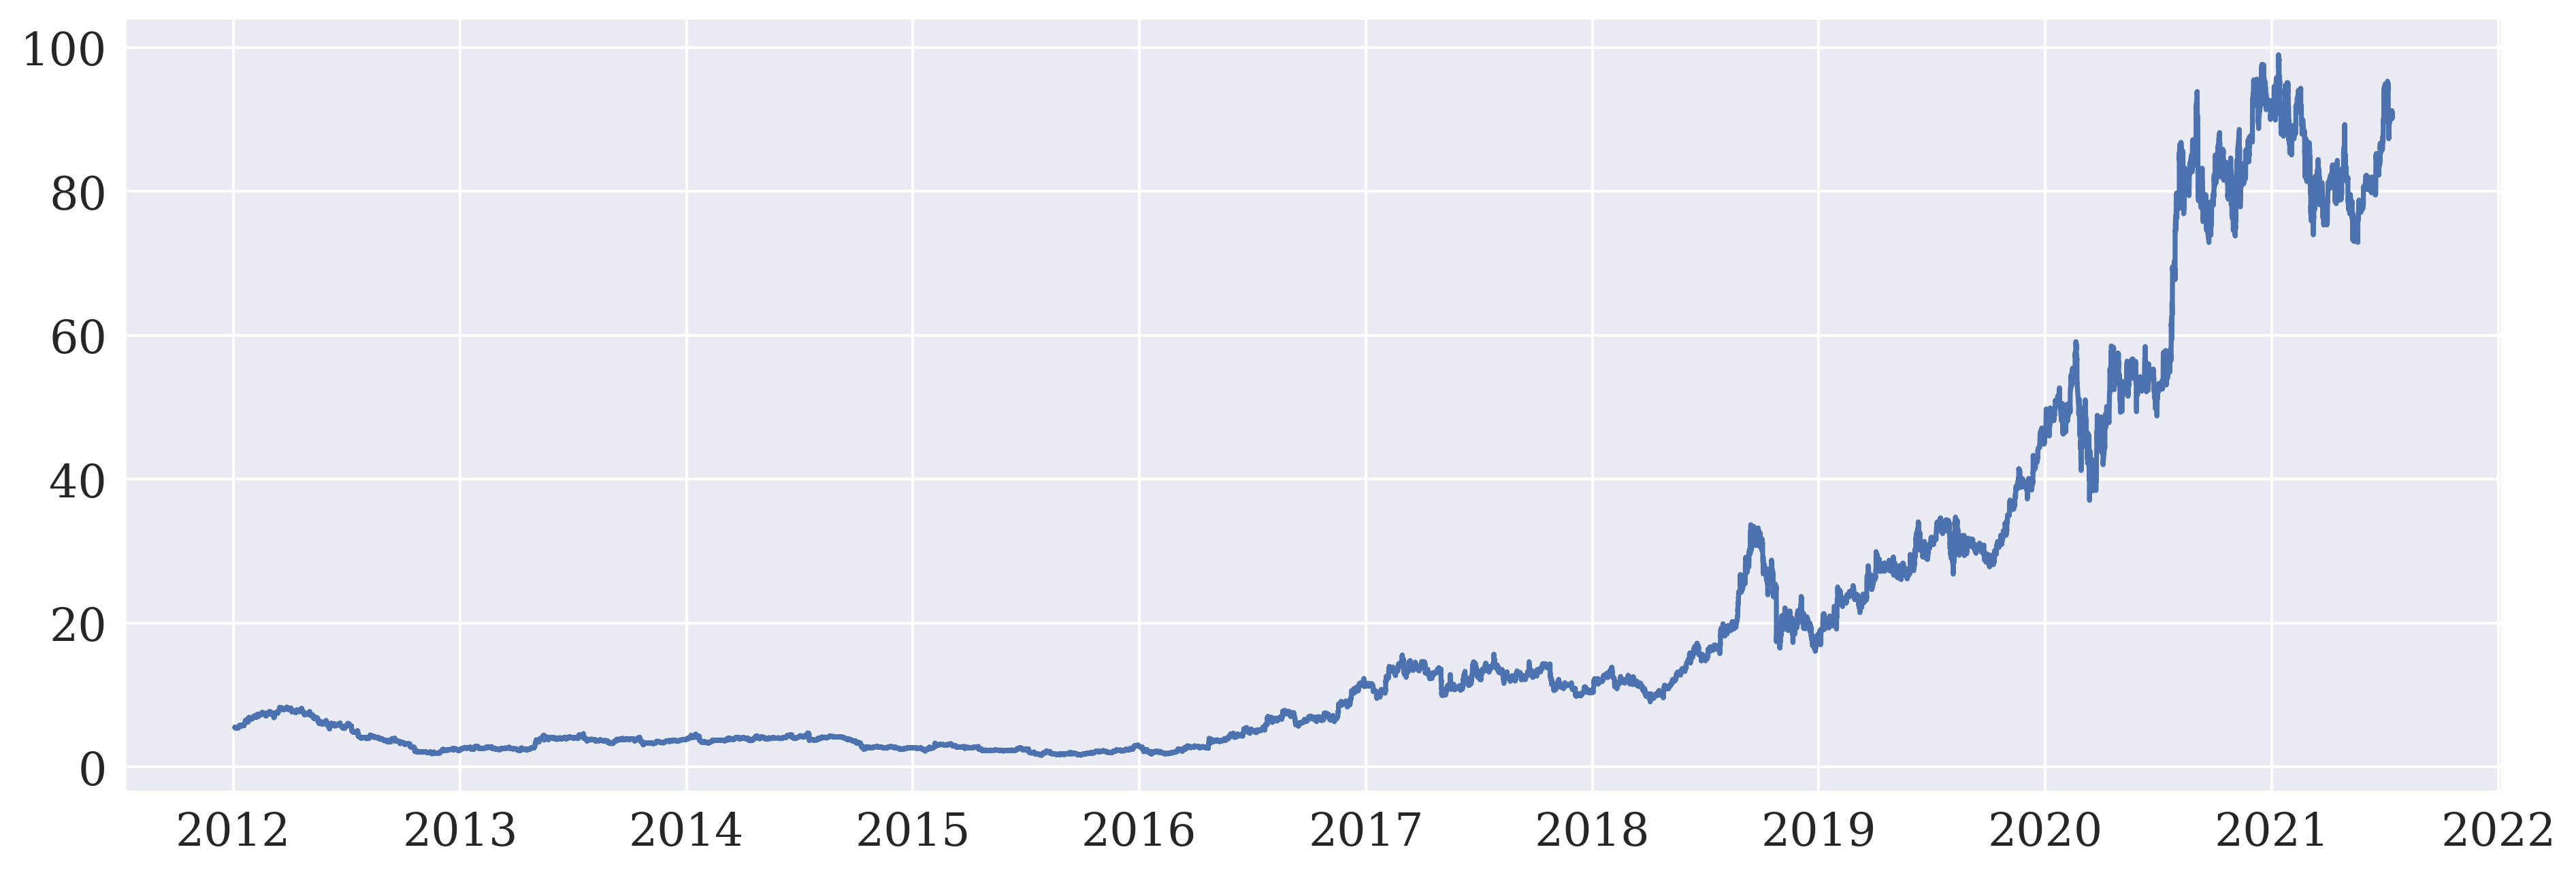

In [10]:
plt.figure(figsize=(15, 5))
plt.plot(data_stock.index, data_stock['close'].values)
plt.grid(True)

In [11]:
counts = barriers.out.value_counts()
counts

 0    13764
-1    11442
 1     8445
Name: out, dtype: int64

In [12]:
counts.sum()

33651

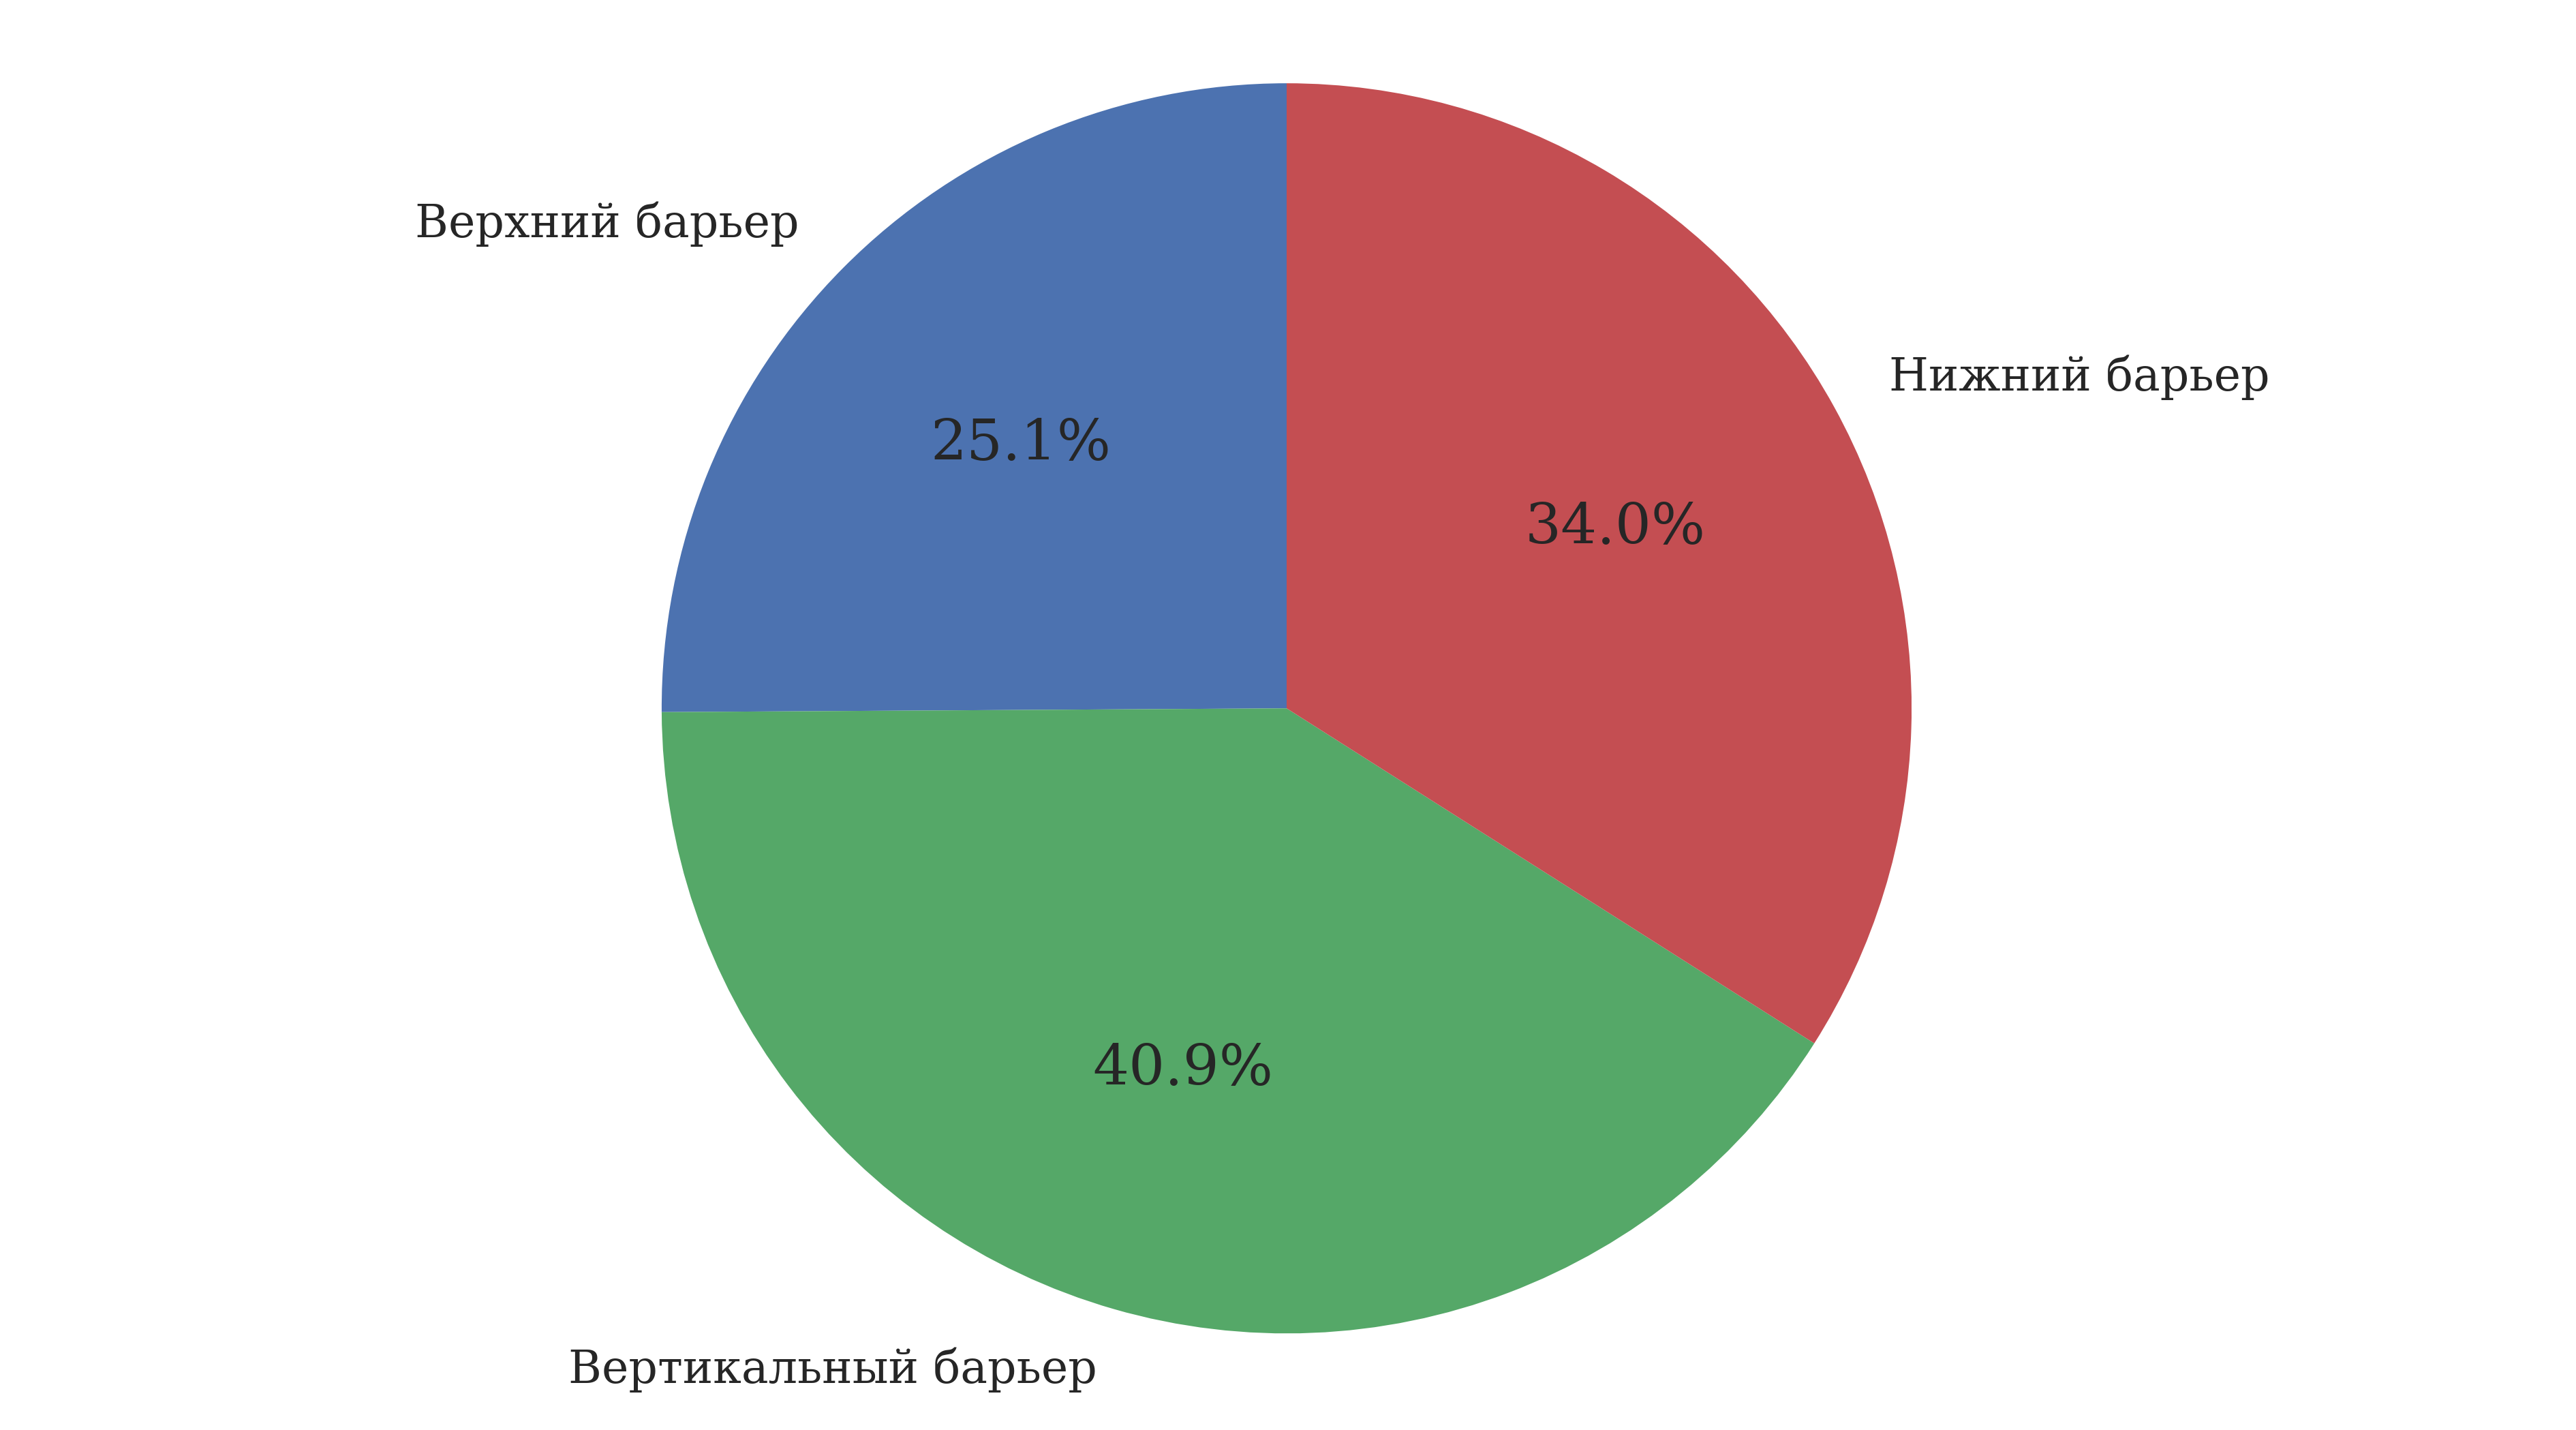

In [13]:
labels = 'Верхний барьер', 'Вертикальный барьер', 'Нижний барьер'
sizes = [(counts[1]*100)/counts.sum(), (counts[0]*100)/counts.sum(), (counts[-1]*100)/counts.sum()]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

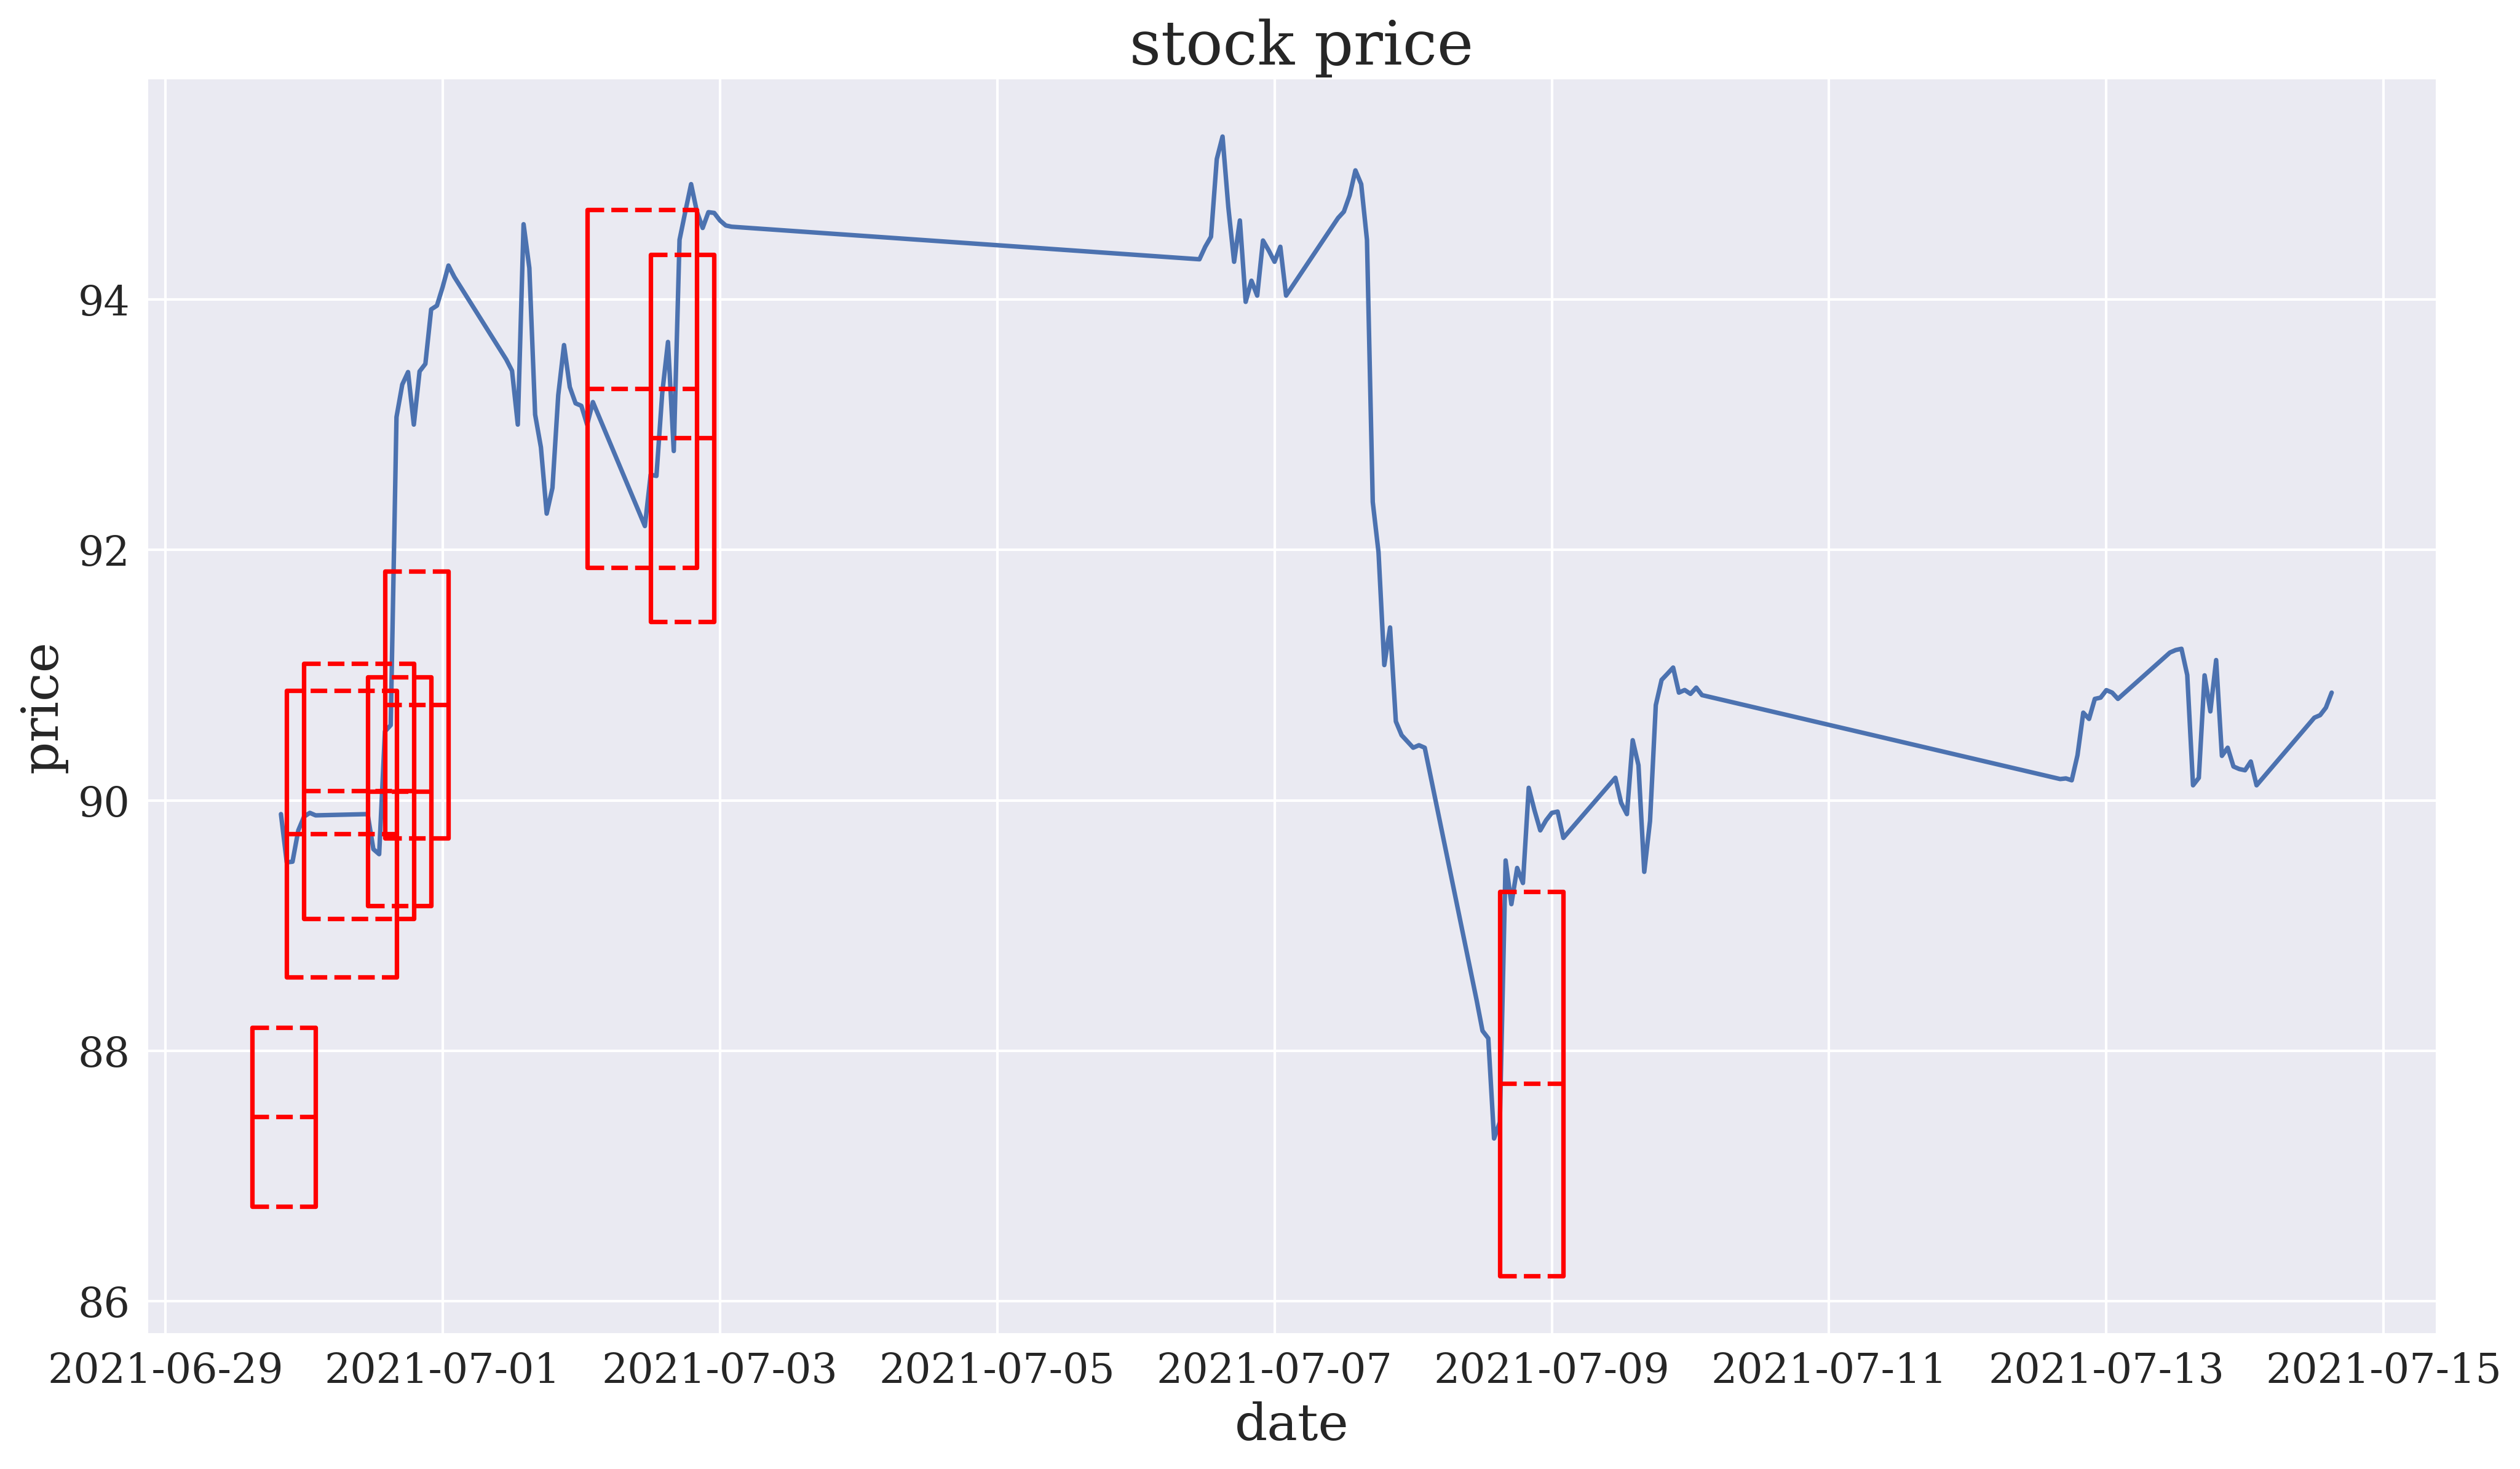

In [14]:
fig,ax = plt.subplots()
ax.set(title=' stock price', xlabel='date', ylabel='price')
ax.plot(barriers.price[-150:])
for i in barriers.index[-155::3]:
    barrier = barriers.loc[i]
    start = i
    end = barrier.vert_barrier
    if not pd.isnull(end) and barrier.out == 1:
        upper_barrier = barrier.top_barrier
        lower_barrier = barrier.bottom_barrier
        ax.plot([start, end], [upper_barrier, upper_barrier], 'r--');
        ax.plot([start, end], [lower_barrier, lower_barrier], 'r--');
        ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, (lower_barrier + upper_barrier)*0.5], 'r--');
        ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
        ax.plot([end, end], [lower_barrier, upper_barrier], 'r-');

In [15]:
def create_HLCV(i): 
    df = pd.DataFrame(index=data_stock.index)
    df[f'high_{i}'] = data_stock.high.rolling(i).max()
    df[f'low_{i}'] = data_stock.low.rolling(i).min()
    df[f'close_{i}'] = data_stock.close.rolling(i).\
                        apply(lambda x:x[-1]) 
    df[f'volume_{i}'] = data_stock.volume.rolling(i).sum()
    df[f'rsi_{i}'] = talib.RSI(data_stock['close']).rolling(i).mean()
    df[f'number_{i}'] = data_stock.number.rolling(i).mean()

    return df

In [16]:
def create_features(i):
    df = create_HLCV(i)
    high = df[f'high_{i}'] + 0.00001
    low = df[f'low_{i}']
    close = df[f'close_{i}']
    volume = df[f'volume_{i}']
    rsi = df[f'rsi_{i}']
    features = pd.DataFrame(index=data_stock.index)
    features[f'volume_{i}'] = volume
    features[f'price_spread_{i}'] = (high - low)
    features[f'close_loc_{i}'] = ((high - close) / (high - low))
    features[f'close_change_{i}'] = close.pct_change(i)
#     features[f'rsi_{i}'] = rsi
    number = df[f'number_{i}']

    return features

In [17]:
def create_bunch_of_features():
    periods = [1,2,3,5,6,7,8,9,10,20,40,60]
    bunch_of_features = pd.DataFrame(index=data_stock.index)
    for period in periods:
        f = create_features(period)
        bunch_of_features = bunch_of_features.join(f)

    macd, macdsignal, macdhist = talib.MACD(data_stock['close'], fastperiod=12, slowperiod=26, signalperiod=9)
    aroondown, aroonup = talib.AROON(data_stock['high'], data_stock['low'], timeperiod=14)
    slowk, slowd = talib.STOCH(data_stock['high'], data_stock['low'], data_stock['close'], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    bunch_of_features['hour'] = data_stock.index.hour
    bunch_of_features['macd'] = macd
    bunch_of_features['macdsignal'] = macdsignal
    bunch_of_features['macdhist'] = macdhist
    bunch_of_features['rsi'] = talib.RSI(data_stock['close'])
    bunch_of_features['adx'] = talib.ADX(data_stock['high'], data_stock['low'], data_stock['close'], timeperiod=14)
    bunch_of_features['adxr'] = talib.ADXR(data_stock['high'], data_stock['low'], data_stock['close'], timeperiod=14)
    bunch_of_features['apo'] = talib.APO(data_stock['close'], fastperiod=12, slowperiod=26, matype=0)
    bunch_of_features['cci'] = talib.CCI(data_stock['high'], data_stock['low'], data_stock['close'], timeperiod=14)
    bunch_of_features['aroondown'] = aroondown
    bunch_of_features['aroonup'] = aroonup
    bunch_of_features['AROONOSC']  = talib.AROONOSC(data_stock['high'], data_stock['low'], timeperiod=14)
    bunch_of_features['BOP']  = talib.BOP(data_stock['open'], data_stock['high'], data_stock['low'], data_stock['close'])
    bunch_of_features['slowk'] = slowk
    bunch_of_features['slowd'] = slowd
    bunch_of_features['CDLHAMMER'] = talib.CDLHAMMER(data_stock['open'], data_stock['high'], data_stock['low'], data_stock['close'])

    return bunch_of_features

bunch_of_features = create_bunch_of_features()
bunch_of_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33664 entries, 2012-01-03 15:00:00 to 2021-07-14 15:00:00
Data columns (total 64 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   volume_1         33664 non-null  float64
 1   price_spread_1   33664 non-null  float64
 2   close_loc_1      33664 non-null  float64
 3   close_change_1   33663 non-null  float64
 4   volume_2         33663 non-null  float64
 5   price_spread_2   33663 non-null  float64
 6   close_loc_2      33663 non-null  float64
 7   close_change_2   33661 non-null  float64
 8   volume_3         33662 non-null  float64
 9   price_spread_3   33662 non-null  float64
 10  close_loc_3      33662 non-null  float64
 11  close_change_3   33659 non-null  float64
 12  volume_5         33660 non-null  float64
 13  price_spread_5   33660 non-null  float64
 14  close_loc_5      33660 non-null  float64
 15  close_change_5   33655 non-null  float64
 16  volume_6         33659 

In [18]:
dropna_barriers = barriers.dropna()
data = bunch_of_features[60:-13].assign(out=dropna_barriers[58:-2].out)
data.dropna(inplace=True)
out = data.out
out=out.astype('int')
data.drop('out', axis=1, inplace=True)
data

,volume_1,price_spread_1,close_loc_1,close_change_1,volume_2,price_spread_2,close_loc_2,close_change_2,volume_3,price_spread_3,...,adxr,apo,cci,aroondown,aroonup,AROONOSC,BOP,slowk,slowd,CDLHAMMER
2012-01-18 18:00:00,3850816.0,0.11001,0.090992,0.011864,5418305.0,0.27001,0.037073,0.041885,5421805.0,0.27001,...,23.445954,0.043071,321.614862,0.000000,100.000000,100.000000,0.727273,70.765432,56.477366,0
2012-01-18 19:00:00,1963240.0,0.05001,0.800040,-0.003350,5814056.0,0.12001,0.333389,0.008475,7381545.0,0.28001,...,24.035533,0.050955,222.925659,85.714286,100.000000,14.285714,-0.200000,94.003527,71.367431,0
2012-01-18 20:00:00,3028753.0,0.09001,0.703366,0.002807,4991993.0,0.09001,0.703366,-0.000553,8842809.0,0.16001,...,24.438133,0.060294,168.072936,78.571429,100.000000,21.428571,0.185556,87.409777,84.059579,0
2012-01-18 21:00:00,2492895.0,0.09001,0.888901,-0.012855,5521648.0,0.15001,0.933338,-0.010084,7484888.0,0.15001,...,24.148018,0.060935,81.869460,71.428571,92.857143,21.428571,-0.777778,74.061012,85.158106,0
2012-01-18 22:00:00,2532483.0,0.07001,0.357235,0.005942,5025378.0,0.09001,0.500056,-0.006989,8054131.0,0.15001,...,23.878625,0.064685,72.370511,64.285714,85.714286,21.428571,0.381429,56.947917,72.806235,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13 13:00:00,1754.0,0.04001,1.000000,0.000110,3997.0,0.08001,0.500062,0.000329,7712.0,0.17001,...,19.486722,0.124437,119.028807,21.428571,7.142857,-14.285714,-0.500000,94.434783,76.580977,0
2021-07-13 14:00:00,25483.0,0.26001,0.923080,-0.002302,27237.0,0.27001,0.925929,-0.002193,29480.0,0.27001,...,19.544452,0.166745,72.495104,14.285714,0.000000,-14.285714,-0.807692,79.942029,83.475210,0
2021-07-13 15:00:00,184039.0,1.14001,0.982456,-0.009670,209522.0,1.14001,0.982456,-0.011950,211276.0,1.15001,...,18.802323,0.120168,-74.740649,7.142857,85.714286,78.571429,-0.982456,47.913043,74.096618,0
2021-07-13 16:00:00,4374003.0,1.03001,0.689809,0.000660,4558042.0,1.38001,0.768480,-0.009016,4583525.0,1.38001,...,18.527567,0.063543,-138.218004,0.000000,78.571429,78.571429,0.009223,24.908247,50.921107,0


In [19]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(iterations=2000, min_data_in_leaf=150, grow_policy="Depthwise")

cat_model.fit(data, out)

Learning rate set to 0.052693
0:	learn: 1.0935682	total: 110ms	remaining: 3m 39s
1:	learn: 1.0891719	total: 160ms	remaining: 2m 39s
2:	learn: 1.0850840	total: 212ms	remaining: 2m 21s
3:	learn: 1.0812449	total: 273ms	remaining: 2m 16s
4:	learn: 1.0776248	total: 326ms	remaining: 2m 10s
5:	learn: 1.0742278	total: 377ms	remaining: 2m 5s
6:	learn: 1.0711949	total: 430ms	remaining: 2m 2s
7:	learn: 1.0684643	total: 483ms	remaining: 2m
8:	learn: 1.0655700	total: 531ms	remaining: 1m 57s
9:	learn: 1.0629629	total: 582ms	remaining: 1m 55s
10:	learn: 1.0606480	total: 632ms	remaining: 1m 54s
11:	learn: 1.0584946	total: 686ms	remaining: 1m 53s
12:	learn: 1.0564361	total: 737ms	remaining: 1m 52s
13:	learn: 1.0542787	total: 786ms	remaining: 1m 51s
14:	learn: 1.0525440	total: 837ms	remaining: 1m 50s
15:	learn: 1.0509659	total: 886ms	remaining: 1m 49s
16:	learn: 1.0494877	total: 941ms	remaining: 1m 49s
17:	learn: 1.0478842	total: 994ms	remaining: 1m 49s
18:	learn: 1.0463056	total: 1.04s	remaining: 1m 48

157:	learn: 0.9655923	total: 7.88s	remaining: 1m 31s
158:	learn: 0.9652466	total: 7.92s	remaining: 1m 31s
159:	learn: 0.9647775	total: 7.98s	remaining: 1m 31s
160:	learn: 0.9644027	total: 8.02s	remaining: 1m 31s
161:	learn: 0.9640412	total: 8.06s	remaining: 1m 31s
162:	learn: 0.9637029	total: 8.11s	remaining: 1m 31s
163:	learn: 0.9633920	total: 8.15s	remaining: 1m 31s
164:	learn: 0.9630456	total: 8.2s	remaining: 1m 31s
165:	learn: 0.9627173	total: 8.24s	remaining: 1m 31s
166:	learn: 0.9620743	total: 8.29s	remaining: 1m 31s
167:	learn: 0.9615777	total: 8.34s	remaining: 1m 30s
168:	learn: 0.9613016	total: 8.39s	remaining: 1m 30s
169:	learn: 0.9610031	total: 8.43s	remaining: 1m 30s
170:	learn: 0.9606720	total: 8.48s	remaining: 1m 30s
171:	learn: 0.9603203	total: 8.53s	remaining: 1m 30s
172:	learn: 0.9601072	total: 8.58s	remaining: 1m 30s
173:	learn: 0.9598282	total: 8.62s	remaining: 1m 30s
174:	learn: 0.9594850	total: 8.67s	remaining: 1m 30s
175:	learn: 0.9592251	total: 8.71s	remaining: 1

314:	learn: 0.8950184	total: 15.2s	remaining: 1m 21s
315:	learn: 0.8946177	total: 15.2s	remaining: 1m 21s
316:	learn: 0.8940187	total: 15.2s	remaining: 1m 20s
317:	learn: 0.8936823	total: 15.3s	remaining: 1m 20s
318:	learn: 0.8930944	total: 15.3s	remaining: 1m 20s
319:	learn: 0.8926913	total: 15.4s	remaining: 1m 20s
320:	learn: 0.8923539	total: 15.4s	remaining: 1m 20s
321:	learn: 0.8919757	total: 15.5s	remaining: 1m 20s
322:	learn: 0.8915693	total: 15.5s	remaining: 1m 20s
323:	learn: 0.8910354	total: 15.6s	remaining: 1m 20s
324:	learn: 0.8906922	total: 15.6s	remaining: 1m 20s
325:	learn: 0.8901586	total: 15.7s	remaining: 1m 20s
326:	learn: 0.8896450	total: 15.7s	remaining: 1m 20s
327:	learn: 0.8892160	total: 15.8s	remaining: 1m 20s
328:	learn: 0.8885118	total: 15.8s	remaining: 1m 20s
329:	learn: 0.8882322	total: 15.9s	remaining: 1m 20s
330:	learn: 0.8878121	total: 15.9s	remaining: 1m 20s
331:	learn: 0.8876224	total: 15.9s	remaining: 1m 20s
332:	learn: 0.8873713	total: 16s	remaining: 1m

472:	learn: 0.8329796	total: 22.5s	remaining: 1m 12s
473:	learn: 0.8326231	total: 22.6s	remaining: 1m 12s
474:	learn: 0.8322582	total: 22.6s	remaining: 1m 12s
475:	learn: 0.8320068	total: 22.7s	remaining: 1m 12s
476:	learn: 0.8318038	total: 22.7s	remaining: 1m 12s
477:	learn: 0.8311788	total: 22.8s	remaining: 1m 12s
478:	learn: 0.8309461	total: 22.8s	remaining: 1m 12s
479:	learn: 0.8306348	total: 22.9s	remaining: 1m 12s
480:	learn: 0.8304349	total: 22.9s	remaining: 1m 12s
481:	learn: 0.8299513	total: 23s	remaining: 1m 12s
482:	learn: 0.8296999	total: 23s	remaining: 1m 12s
483:	learn: 0.8291889	total: 23.1s	remaining: 1m 12s
484:	learn: 0.8286553	total: 23.1s	remaining: 1m 12s
485:	learn: 0.8280830	total: 23.2s	remaining: 1m 12s
486:	learn: 0.8276671	total: 23.2s	remaining: 1m 12s
487:	learn: 0.8275081	total: 23.3s	remaining: 1m 12s
488:	learn: 0.8271734	total: 23.3s	remaining: 1m 12s
489:	learn: 0.8269288	total: 23.4s	remaining: 1m 12s
490:	learn: 0.8264099	total: 23.4s	remaining: 1m 1

631:	learn: 0.7787460	total: 30.2s	remaining: 1m 5s
632:	learn: 0.7785718	total: 30.2s	remaining: 1m 5s
633:	learn: 0.7781654	total: 30.2s	remaining: 1m 5s
634:	learn: 0.7778686	total: 30.3s	remaining: 1m 5s
635:	learn: 0.7776487	total: 30.3s	remaining: 1m 5s
636:	learn: 0.7770602	total: 30.4s	remaining: 1m 5s
637:	learn: 0.7768461	total: 30.4s	remaining: 1m 4s
638:	learn: 0.7766031	total: 30.5s	remaining: 1m 4s
639:	learn: 0.7761671	total: 30.5s	remaining: 1m 4s
640:	learn: 0.7758556	total: 30.6s	remaining: 1m 4s
641:	learn: 0.7757453	total: 30.6s	remaining: 1m 4s
642:	learn: 0.7752589	total: 30.7s	remaining: 1m 4s
643:	learn: 0.7751221	total: 30.7s	remaining: 1m 4s
644:	learn: 0.7746791	total: 30.8s	remaining: 1m 4s
645:	learn: 0.7745062	total: 30.8s	remaining: 1m 4s
646:	learn: 0.7741807	total: 30.9s	remaining: 1m 4s
647:	learn: 0.7739521	total: 30.9s	remaining: 1m 4s
648:	learn: 0.7737323	total: 30.9s	remaining: 1m 4s
649:	learn: 0.7734993	total: 31s	remaining: 1m 4s
650:	learn: 0.

791:	learn: 0.7329323	total: 37.7s	remaining: 57.6s
792:	learn: 0.7325412	total: 37.8s	remaining: 57.5s
793:	learn: 0.7322596	total: 37.8s	remaining: 57.5s
794:	learn: 0.7321849	total: 37.9s	remaining: 57.4s
795:	learn: 0.7317841	total: 37.9s	remaining: 57.4s
796:	learn: 0.7315561	total: 38s	remaining: 57.3s
797:	learn: 0.7313593	total: 38s	remaining: 57.3s
798:	learn: 0.7311352	total: 38.1s	remaining: 57.2s
799:	learn: 0.7309311	total: 38.1s	remaining: 57.2s
800:	learn: 0.7306628	total: 38.2s	remaining: 57.1s
801:	learn: 0.7303781	total: 38.2s	remaining: 57.1s
802:	learn: 0.7302076	total: 38.3s	remaining: 57s
803:	learn: 0.7300533	total: 38.3s	remaining: 57s
804:	learn: 0.7298726	total: 38.4s	remaining: 56.9s
805:	learn: 0.7296411	total: 38.4s	remaining: 56.9s
806:	learn: 0.7294259	total: 38.4s	remaining: 56.8s
807:	learn: 0.7292653	total: 38.5s	remaining: 56.8s
808:	learn: 0.7289964	total: 38.5s	remaining: 56.7s
809:	learn: 0.7283042	total: 38.6s	remaining: 56.7s
810:	learn: 0.727971

951:	learn: 0.6935832	total: 45.4s	remaining: 49.9s
952:	learn: 0.6932954	total: 45.4s	remaining: 49.9s
953:	learn: 0.6930483	total: 45.4s	remaining: 49.8s
954:	learn: 0.6927995	total: 45.5s	remaining: 49.8s
955:	learn: 0.6926054	total: 45.5s	remaining: 49.7s
956:	learn: 0.6924053	total: 45.6s	remaining: 49.7s
957:	learn: 0.6917546	total: 45.6s	remaining: 49.6s
958:	learn: 0.6914310	total: 45.7s	remaining: 49.6s
959:	learn: 0.6912398	total: 45.7s	remaining: 49.6s
960:	learn: 0.6910910	total: 45.8s	remaining: 49.5s
961:	learn: 0.6909016	total: 45.8s	remaining: 49.5s
962:	learn: 0.6907833	total: 45.9s	remaining: 49.4s
963:	learn: 0.6906619	total: 45.9s	remaining: 49.4s
964:	learn: 0.6904618	total: 46s	remaining: 49.3s
965:	learn: 0.6900662	total: 46s	remaining: 49.3s
966:	learn: 0.6898014	total: 46.1s	remaining: 49.2s
967:	learn: 0.6896130	total: 46.1s	remaining: 49.2s
968:	learn: 0.6893254	total: 46.2s	remaining: 49.1s
969:	learn: 0.6889884	total: 46.2s	remaining: 49.1s
970:	learn: 0.68

1110:	learn: 0.6565222	total: 53s	remaining: 42.4s
1111:	learn: 0.6563123	total: 53.1s	remaining: 42.4s
1112:	learn: 0.6561475	total: 53.1s	remaining: 42.3s
1113:	learn: 0.6557281	total: 53.1s	remaining: 42.3s
1114:	learn: 0.6554432	total: 53.2s	remaining: 42.2s
1115:	learn: 0.6551943	total: 53.2s	remaining: 42.2s
1116:	learn: 0.6549278	total: 53.3s	remaining: 42.1s
1117:	learn: 0.6546976	total: 53.3s	remaining: 42.1s
1118:	learn: 0.6544588	total: 53.4s	remaining: 42s
1119:	learn: 0.6542283	total: 53.4s	remaining: 42s
1120:	learn: 0.6540416	total: 53.5s	remaining: 41.9s
1121:	learn: 0.6537942	total: 53.5s	remaining: 41.9s
1122:	learn: 0.6536503	total: 53.6s	remaining: 41.8s
1123:	learn: 0.6534372	total: 53.6s	remaining: 41.8s
1124:	learn: 0.6532044	total: 53.7s	remaining: 41.7s
1125:	learn: 0.6529501	total: 53.7s	remaining: 41.7s
1126:	learn: 0.6527008	total: 53.8s	remaining: 41.7s
1127:	learn: 0.6525311	total: 53.8s	remaining: 41.6s
1128:	learn: 0.6523223	total: 53.9s	remaining: 41.6s

1271:	learn: 0.6231902	total: 1m	remaining: 34.8s
1272:	learn: 0.6230377	total: 1m	remaining: 34.8s
1273:	learn: 0.6228026	total: 1m	remaining: 34.7s
1274:	learn: 0.6225796	total: 1m 1s	remaining: 34.7s
1275:	learn: 0.6223966	total: 1m 1s	remaining: 34.7s
1276:	learn: 0.6221935	total: 1m 1s	remaining: 34.6s
1277:	learn: 0.6220609	total: 1m 1s	remaining: 34.6s
1278:	learn: 0.6218454	total: 1m 1s	remaining: 34.5s
1279:	learn: 0.6216486	total: 1m 1s	remaining: 34.5s
1280:	learn: 0.6214868	total: 1m 1s	remaining: 34.4s
1281:	learn: 0.6212614	total: 1m 1s	remaining: 34.4s
1282:	learn: 0.6209083	total: 1m 1s	remaining: 34.3s
1283:	learn: 0.6206320	total: 1m 1s	remaining: 34.3s
1284:	learn: 0.6204630	total: 1m 1s	remaining: 34.2s
1285:	learn: 0.6202909	total: 1m 1s	remaining: 34.2s
1286:	learn: 0.6200810	total: 1m 1s	remaining: 34.1s
1287:	learn: 0.6198358	total: 1m 1s	remaining: 34.1s
1288:	learn: 0.6195911	total: 1m 1s	remaining: 34s
1289:	learn: 0.6195094	total: 1m 1s	remaining: 34s
1290:	

1429:	learn: 0.5909534	total: 1m 8s	remaining: 27.4s
1430:	learn: 0.5908177	total: 1m 8s	remaining: 27.3s
1431:	learn: 0.5906337	total: 1m 8s	remaining: 27.3s
1432:	learn: 0.5905337	total: 1m 8s	remaining: 27.2s
1433:	learn: 0.5900840	total: 1m 8s	remaining: 27.2s
1434:	learn: 0.5899896	total: 1m 8s	remaining: 27.1s
1435:	learn: 0.5898233	total: 1m 8s	remaining: 27.1s
1436:	learn: 0.5896558	total: 1m 8s	remaining: 27s
1437:	learn: 0.5894671	total: 1m 9s	remaining: 27s
1438:	learn: 0.5893500	total: 1m 9s	remaining: 26.9s
1439:	learn: 0.5891255	total: 1m 9s	remaining: 26.9s
1440:	learn: 0.5889386	total: 1m 9s	remaining: 26.8s
1441:	learn: 0.5887209	total: 1m 9s	remaining: 26.8s
1442:	learn: 0.5885305	total: 1m 9s	remaining: 26.7s
1443:	learn: 0.5883428	total: 1m 9s	remaining: 26.7s
1444:	learn: 0.5881279	total: 1m 9s	remaining: 26.6s
1445:	learn: 0.5880782	total: 1m 9s	remaining: 26.6s
1446:	learn: 0.5878101	total: 1m 9s	remaining: 26.5s
1447:	learn: 0.5877261	total: 1m 9s	remaining: 26.

1585:	learn: 0.5635534	total: 1m 16s	remaining: 19.9s
1586:	learn: 0.5634656	total: 1m 16s	remaining: 19.9s
1587:	learn: 0.5633155	total: 1m 16s	remaining: 19.8s
1588:	learn: 0.5632534	total: 1m 16s	remaining: 19.8s
1589:	learn: 0.5631974	total: 1m 16s	remaining: 19.7s
1590:	learn: 0.5630576	total: 1m 16s	remaining: 19.7s
1591:	learn: 0.5627726	total: 1m 16s	remaining: 19.6s
1592:	learn: 0.5626592	total: 1m 16s	remaining: 19.6s
1593:	learn: 0.5624621	total: 1m 16s	remaining: 19.5s
1594:	learn: 0.5622905	total: 1m 16s	remaining: 19.5s
1595:	learn: 0.5619214	total: 1m 16s	remaining: 19.4s
1596:	learn: 0.5618184	total: 1m 16s	remaining: 19.4s
1597:	learn: 0.5616895	total: 1m 16s	remaining: 19.3s
1598:	learn: 0.5615730	total: 1m 16s	remaining: 19.3s
1599:	learn: 0.5614484	total: 1m 16s	remaining: 19.2s
1600:	learn: 0.5612825	total: 1m 17s	remaining: 19.2s
1601:	learn: 0.5611378	total: 1m 17s	remaining: 19.1s
1602:	learn: 0.5609114	total: 1m 17s	remaining: 19.1s
1603:	learn: 0.5607862	total

1742:	learn: 0.5373137	total: 1m 23s	remaining: 12.4s
1743:	learn: 0.5372271	total: 1m 23s	remaining: 12.3s
1744:	learn: 0.5370123	total: 1m 24s	remaining: 12.3s
1745:	learn: 0.5367642	total: 1m 24s	remaining: 12.2s
1746:	learn: 0.5365868	total: 1m 24s	remaining: 12.2s
1747:	learn: 0.5364126	total: 1m 24s	remaining: 12.1s
1748:	learn: 0.5361993	total: 1m 24s	remaining: 12.1s
1749:	learn: 0.5360973	total: 1m 24s	remaining: 12s
1750:	learn: 0.5358083	total: 1m 24s	remaining: 12s
1751:	learn: 0.5356753	total: 1m 24s	remaining: 11.9s
1752:	learn: 0.5355772	total: 1m 24s	remaining: 11.9s
1753:	learn: 0.5354589	total: 1m 24s	remaining: 11.8s
1754:	learn: 0.5353394	total: 1m 24s	remaining: 11.8s
1755:	learn: 0.5352294	total: 1m 24s	remaining: 11.8s
1756:	learn: 0.5350871	total: 1m 24s	remaining: 11.7s
1757:	learn: 0.5349797	total: 1m 24s	remaining: 11.7s
1758:	learn: 0.5347386	total: 1m 24s	remaining: 11.6s
1759:	learn: 0.5345836	total: 1m 24s	remaining: 11.6s
1760:	learn: 0.5344548	total: 1m

1897:	learn: 0.5123263	total: 1m 31s	remaining: 4.91s
1898:	learn: 0.5122520	total: 1m 31s	remaining: 4.86s
1899:	learn: 0.5120505	total: 1m 31s	remaining: 4.81s
1900:	learn: 0.5119447	total: 1m 31s	remaining: 4.77s
1901:	learn: 0.5117254	total: 1m 31s	remaining: 4.72s
1902:	learn: 0.5115815	total: 1m 31s	remaining: 4.67s
1903:	learn: 0.5113970	total: 1m 31s	remaining: 4.62s
1904:	learn: 0.5112704	total: 1m 31s	remaining: 4.57s
1905:	learn: 0.5110716	total: 1m 31s	remaining: 4.53s
1906:	learn: 0.5110082	total: 1m 31s	remaining: 4.48s
1907:	learn: 0.5108527	total: 1m 31s	remaining: 4.43s
1908:	learn: 0.5106889	total: 1m 31s	remaining: 4.38s
1909:	learn: 0.5105653	total: 1m 31s	remaining: 4.33s
1910:	learn: 0.5104348	total: 1m 32s	remaining: 4.28s
1911:	learn: 0.5103598	total: 1m 32s	remaining: 4.24s
1912:	learn: 0.5102102	total: 1m 32s	remaining: 4.19s
1913:	learn: 0.5101112	total: 1m 32s	remaining: 4.14s
1914:	learn: 0.5099783	total: 1m 32s	remaining: 4.09s
1915:	learn: 0.5098179	total

In [20]:
catboost_predictions = cat_model.predict(bunch_of_features[-30:])

In [21]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(max_depth=100)

xgb_clf.fit(data, out)

y_xgboost_predictions = xgb_clf.predict(bunch_of_features[-30:])

/Users/germanignatovich/Desktop/work/Диплом/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:20:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [22]:
import lightgbm as lgb

lgb_clf = lgb.LGBMClassifier(num_leaves =100)

lgb_clf.fit(data, out)

lgb_predictions = lgb_clf.predict(bunch_of_features[-30:])

In [23]:
from sklearn.ensemble import RandomForestClassifier

rfc_clf = RandomForestClassifier(n_estimators=1000, bootstrap=True, criterion="entropy", max_depth=15, min_samples_leaf=100)
rfc_clf.fit(data, out)

RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=100,
                       n_estimators=1000)

In [24]:
rfc_predictions = rfc_clf.predict(bunch_of_features.iloc[-30:])

In [25]:
new_barriers = barriers[-30:].assign(catboost_predictions=catboost_predictions[:,0])
new_barriers = new_barriers.assign(rfc_predictions=rfc_predictions)
new_barriers = new_barriers.assign(y_xgboost_predictions=y_xgboost_predictions)
new_barriers = new_barriers.assign(lgb_predictions=lgb_predictions)
new_barriers

,days_passed,price,vert_barrier,top_barrier,bottom_barrier,out,catboost_predictions,rfc_predictions,y_xgboost_predictions,lgb_predictions
2021-07-12 17:00:00,33633,90.175,2021-07-13 12:00:00,91.531651,89.270566,0,0,0,0,0
2021-07-12 18:00:00,33634,90.16,2021-07-13 13:00:00,91.461058,89.292628,0,0,0,0,0
2021-07-12 19:00:00,33635,90.36,2021-07-13 14:00:00,91.624429,89.517048,0,0,0,0,0
2021-07-12 20:00:00,33636,90.7,2021-07-13 15:00:00,91.950979,89.866014,0,0,0,0,0
2021-07-12 21:00:00,33637,90.65,2021-07-13 16:00:00,91.850748,89.849501,0,0,0,0,0
2021-07-12 22:00:00,33638,90.81,2021-07-13 17:00:00,91.969906,90.036729,0,0,0,0,0
2021-07-12 23:00:00,33639,90.82,2021-07-13 18:00:00,91.932768,90.078154,0,0,0,0,0
2021-07-13 00:00:00,33640,90.88,2021-07-13 19:00:00,91.948393,90.167738,-1,-1,-1,-1,-1
2021-07-13 01:00:00,33641,90.86,2021-07-13 20:00:00,91.885365,90.176423,-1,-1,-1,-1,-1
2021-07-13 02:00:00,33642,90.81,2021-07-13 21:00:00,91.794953,90.153365,-1,-1,-1,-1,-1


In [26]:
new_barriers.to_excel('/Users/germanignatovich/Desktop/work/Диплом/excel/%s.xlsx' % (symbol + ' ' + new_barriers.index[-1].strftime("%Y-%m-%d_%H:%M:%S")))



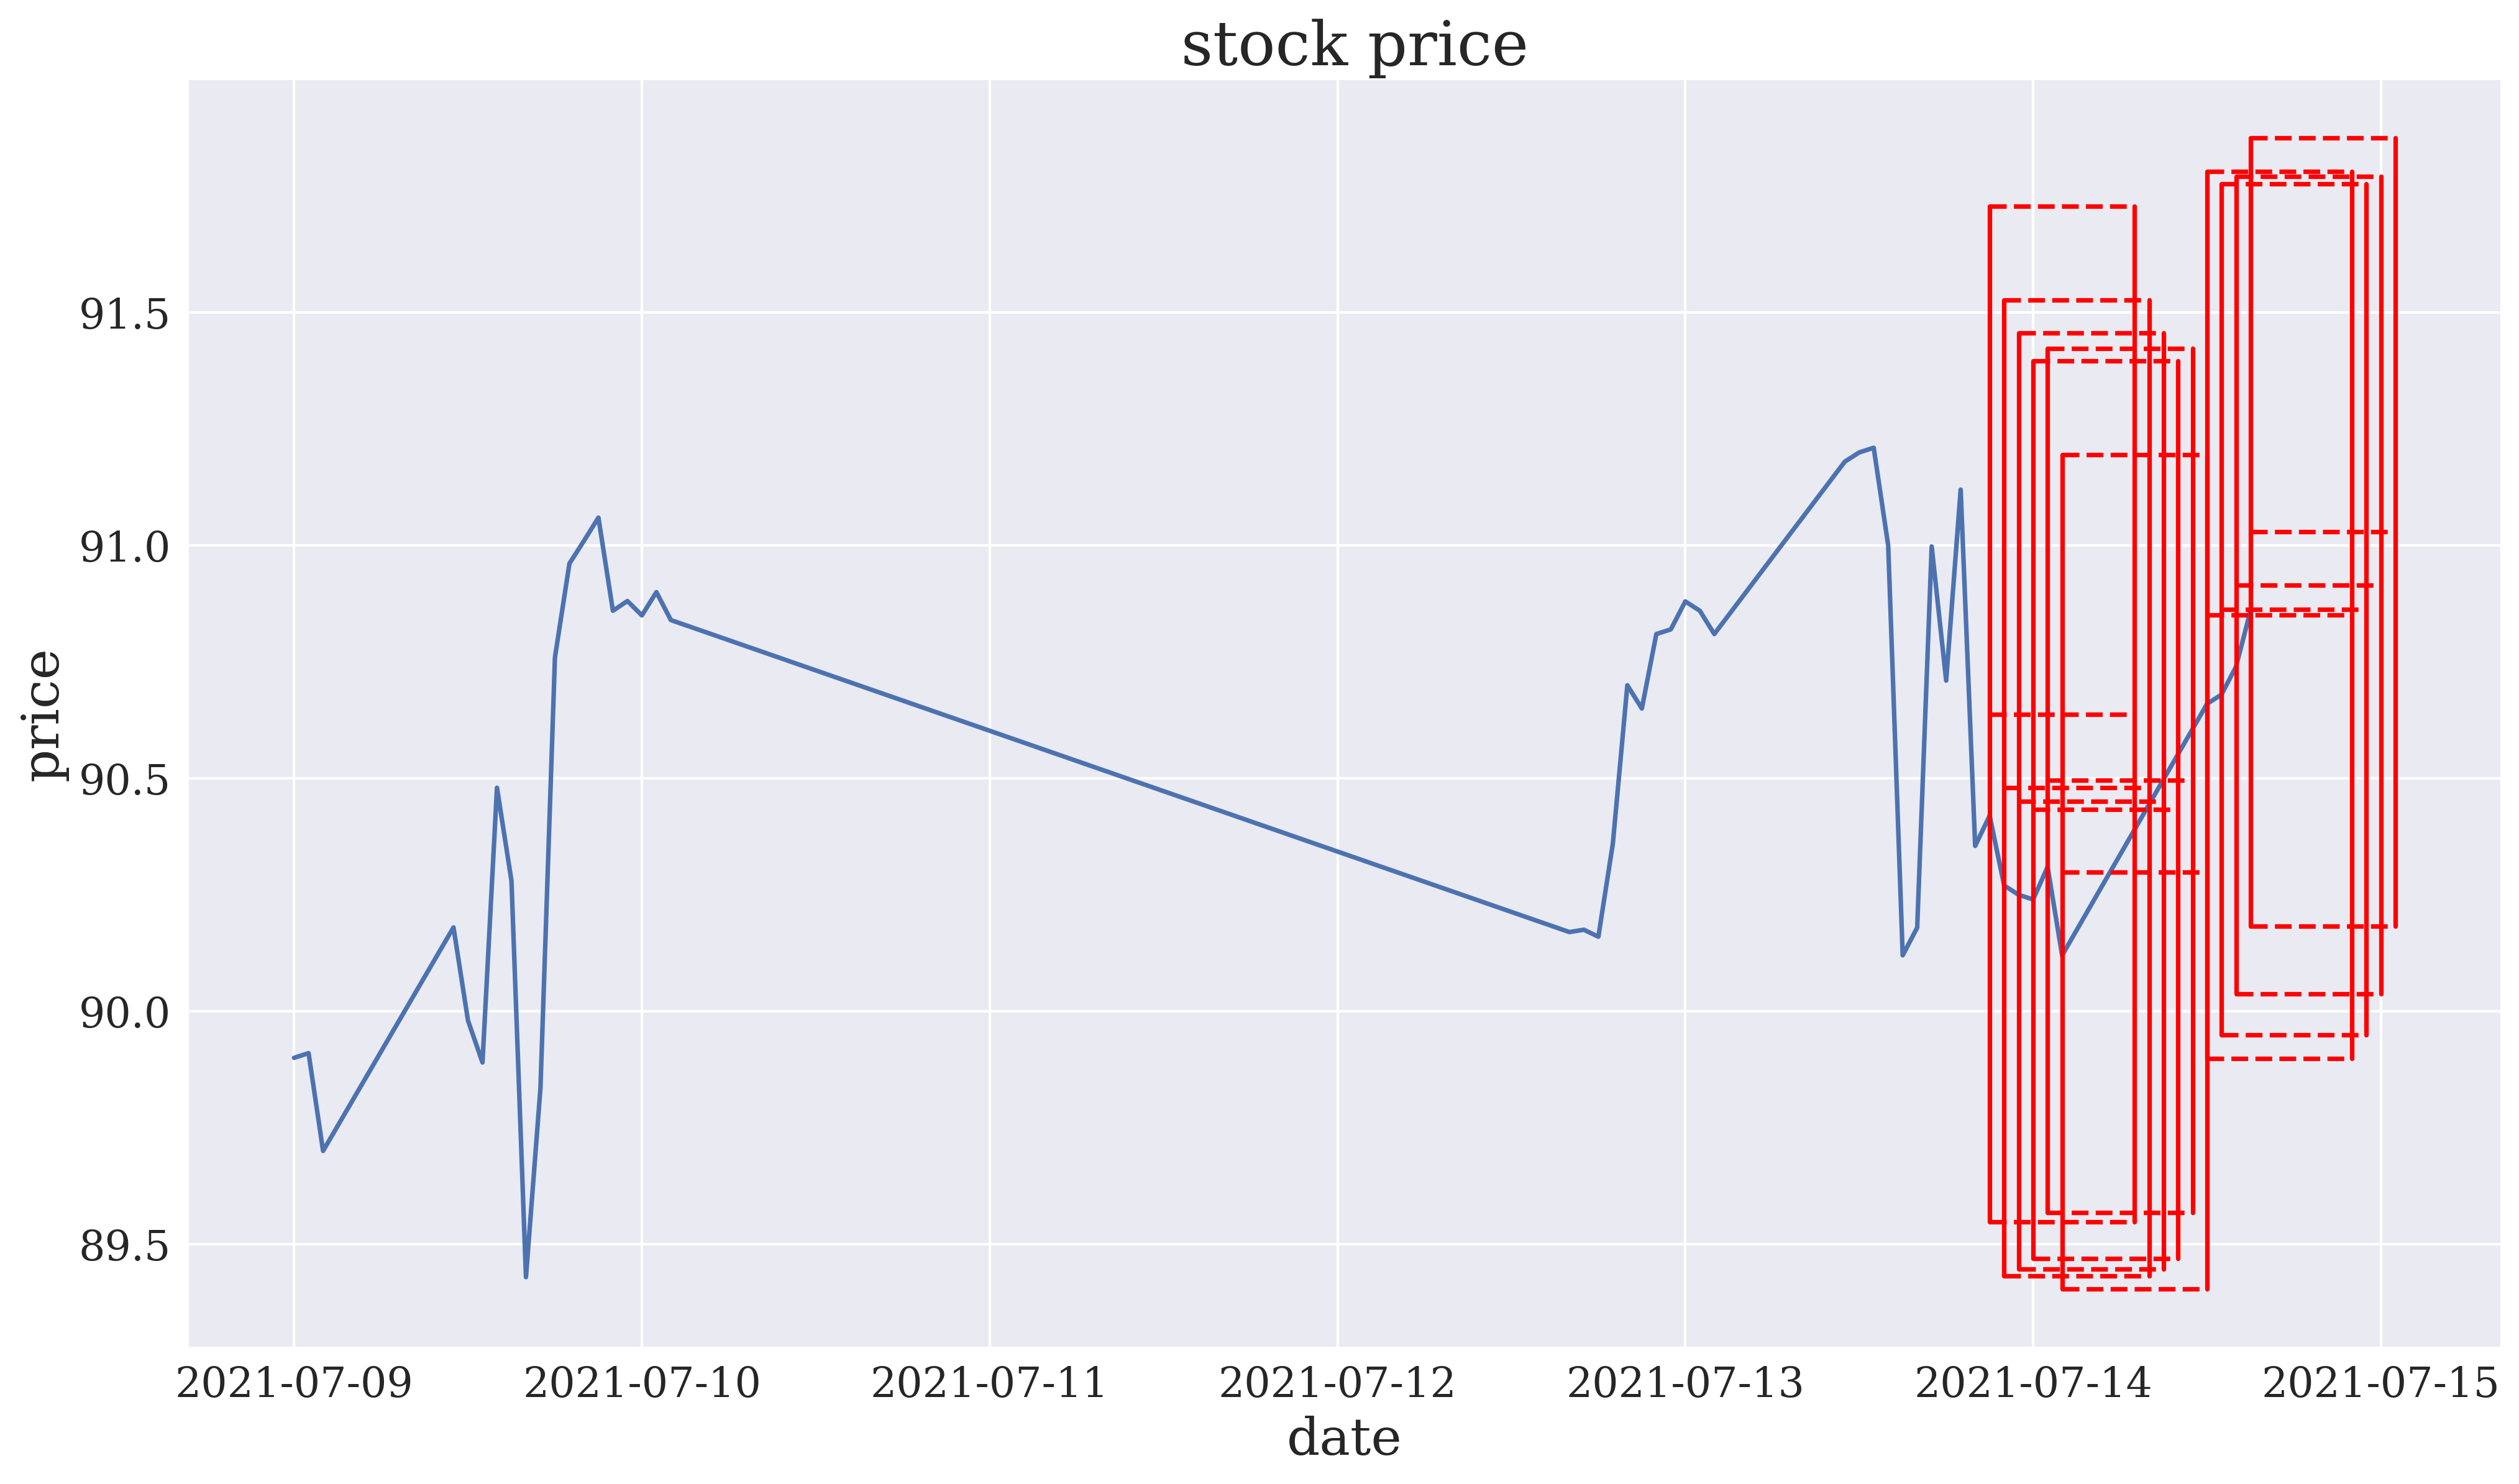

In [27]:
fig,ax = plt.subplots()
ax.set(title=' stock price', xlabel='date', ylabel='price')
ax.plot(barriers.price[-50:])
for i in barriers.index[-10:]:
    barrier = barriers.loc[i]
    start = i
    end = (datetime.strptime(i.strftime("%Y-%m-%d %H:%M:%S"), '%Y-%m-%d %H:%M:%S') + timedelta(hours = 10))
    upper_barrier = barrier.top_barrier
    lower_barrier = barrier.bottom_barrier
    ax.plot([start, end], [upper_barrier, upper_barrier], 'r--');
    ax.plot([start, end], [lower_barrier, lower_barrier], 'r--');
    ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, (lower_barrier + upper_barrier)*0.5], 'r--');
    ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
    ax.plot([end, end], [lower_barrier, upper_barrier], 'r-');

In [ ]:
# estimator = rfc_clf.estimators_[5]

# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(estimator, out_file='tree.dot')

# from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# anya_rfc_clf = RandomForestClassifier(n_estimators=10, criterion="gini", max_depth=6)
# anya_rfc_clf.fit(data, out)

In [ ]:
# estimator = anya_rfc_clf.estimators_[3]

# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(estimator, out_file='Andrew_tree.dot')

# from subprocess import call
# call(['dot', '-Tpng', 'Andrew_tree.dot', '-o', 'Andrew_tree.png', '-Gdpi=800'])

In [45]:
u=np.array([3,0,1,1,1])
v=np.array([0,1,0,2,-2])
w=np.array([1,-4,-1,0,-2])

In [56]:
u/np.linalg.norm(u)

array([0.8660254 , 0.        , 0.28867513, 0.28867513, 0.28867513])